In [1]:
import csv
import pandas as pd
import numpy as np
import json
from datetime import datetime
import matplotlib.pyplot as plt
import re
import seaborn as sns
import scipy.stats as stats
import pytz

In [2]:
features_df = pd.read_csv("features_for_classification.csv", delimiter=",")

## Распределения числовых признаков (гистограммы)

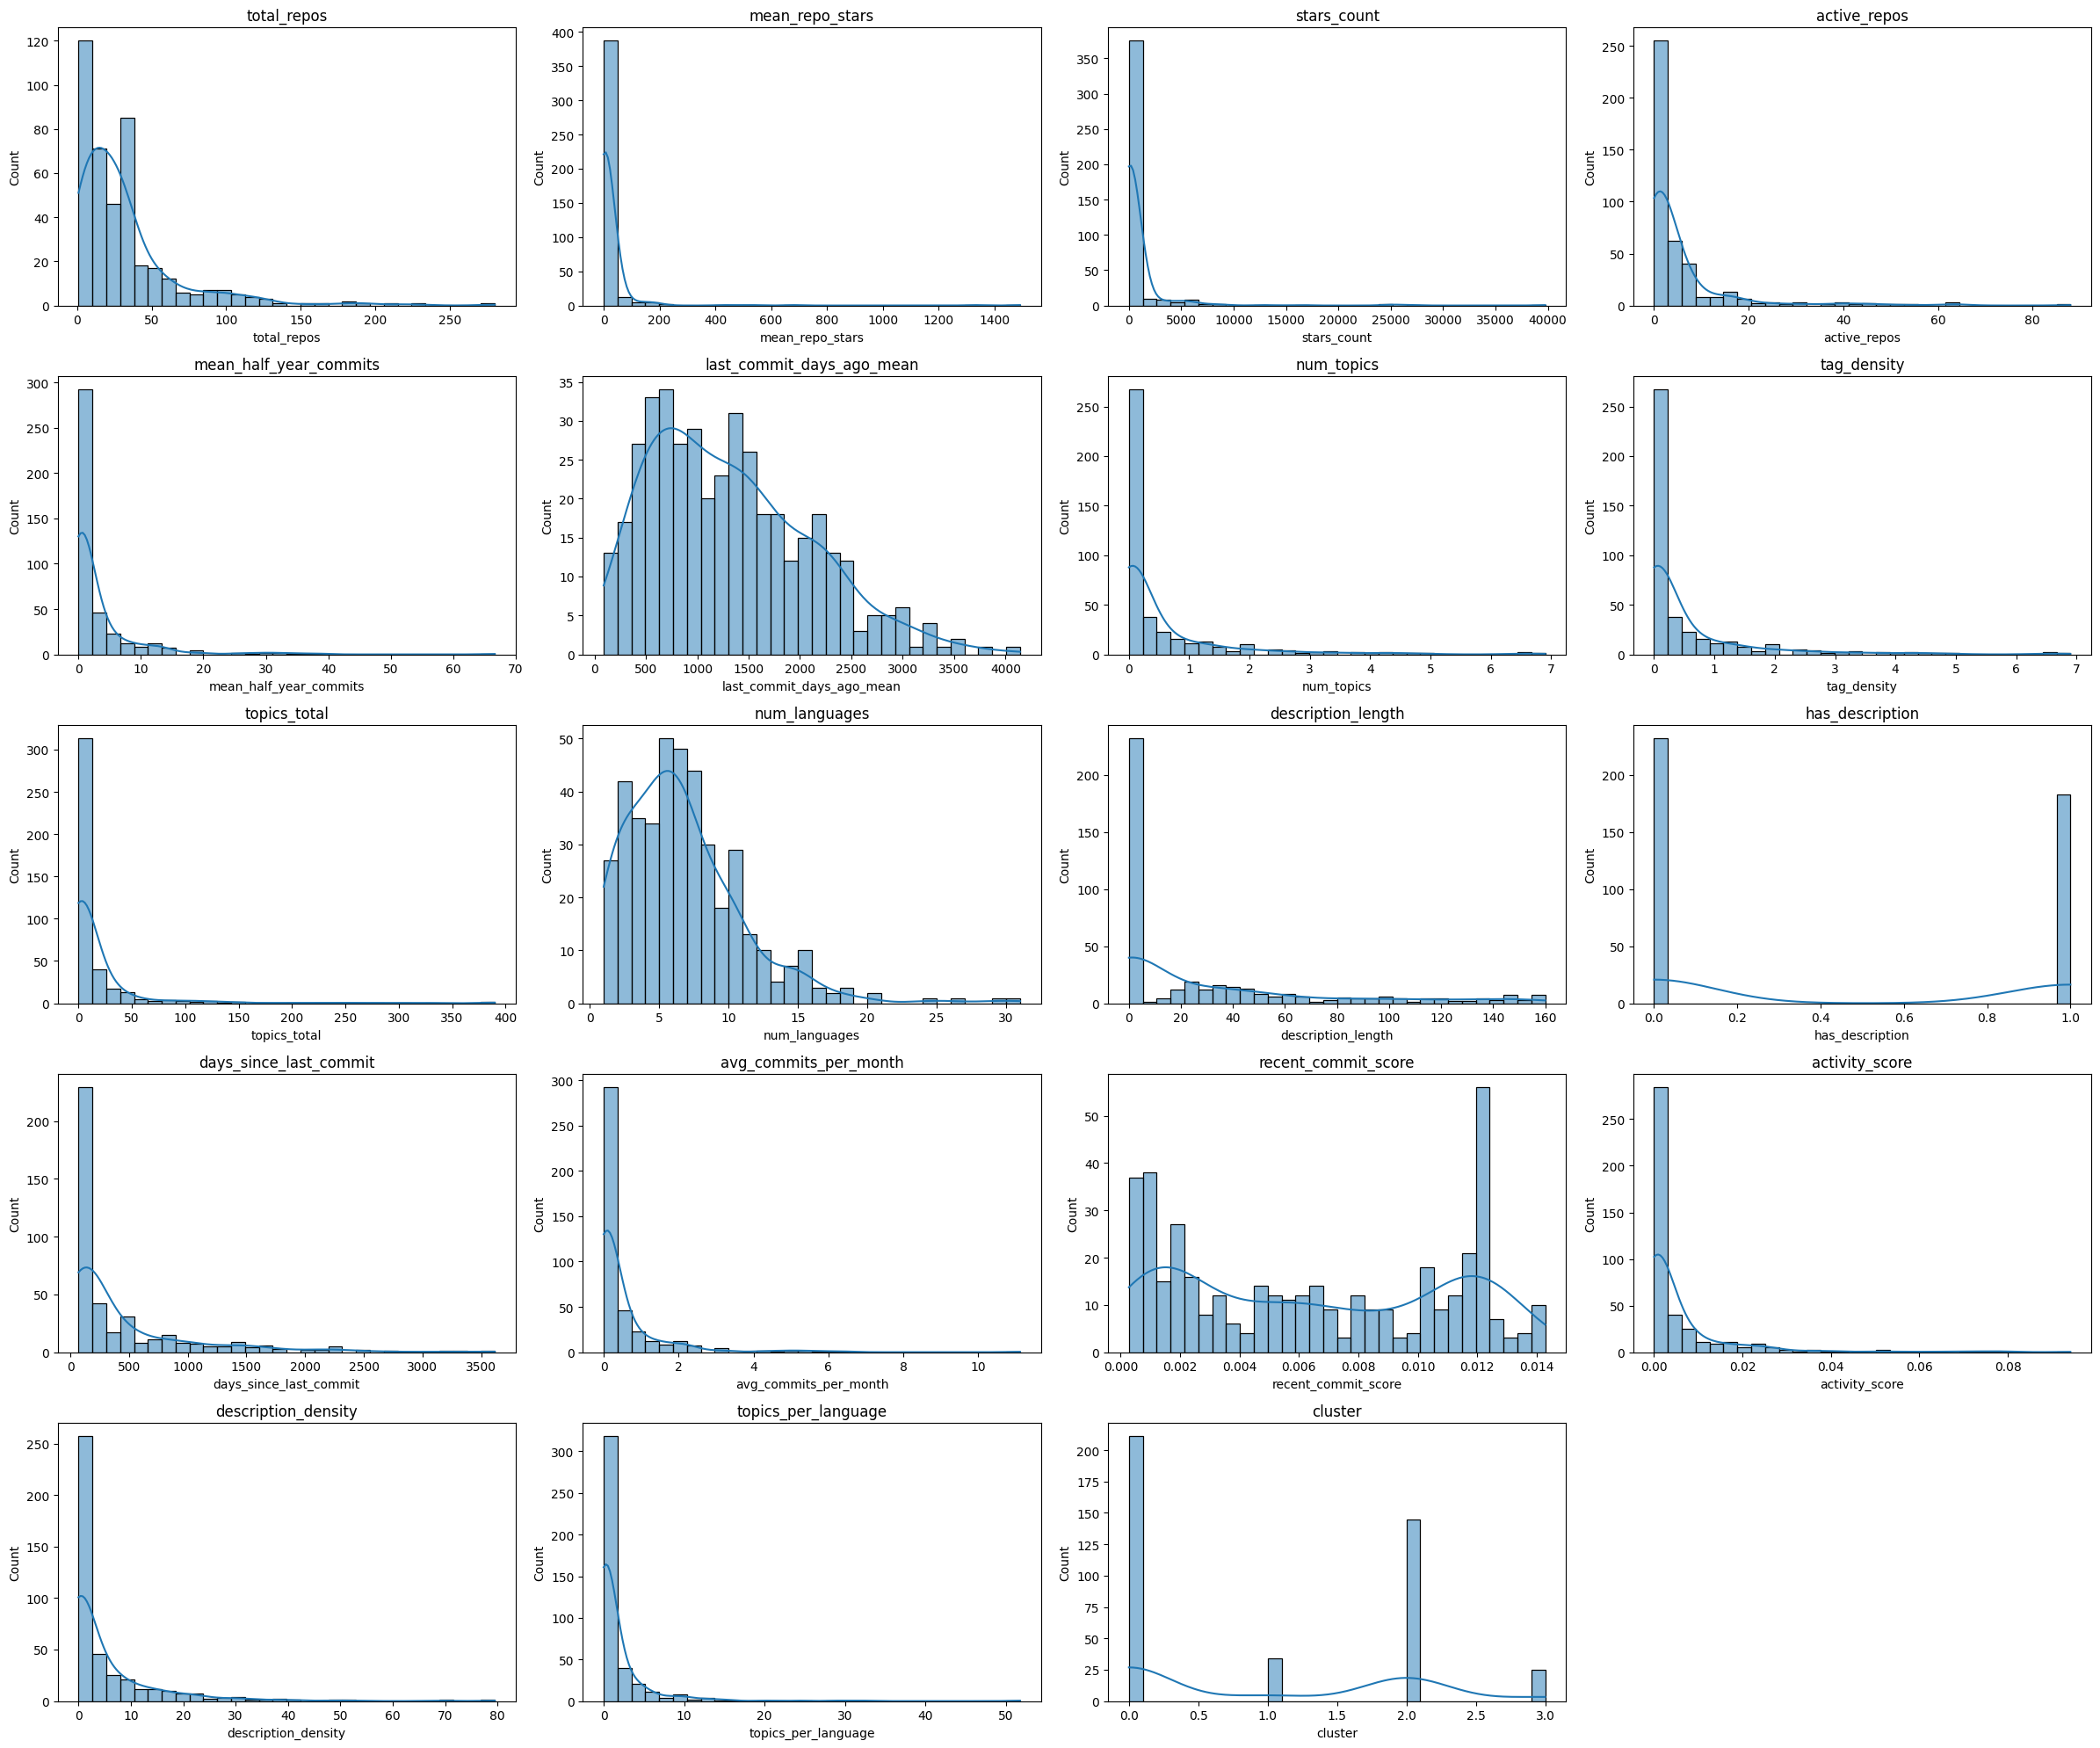

In [14]:
numeric_cols = features_df.select_dtypes(include='number')

num_plots = len(numeric_cols.columns)
cols_per_row = 4
rows = (num_plots + cols_per_row - 1) // cols_per_row

plt.figure(figsize=(cols_per_row * 6, rows * 4))
for i, col in enumerate(numeric_cols.columns, 1):
    plt.subplot(rows, cols_per_row, i)
    sns.histplot(features_df[col], kde=True, bins=30)
    plt.title(col)
plt.tight_layout()
plt.show()


## Корреляционная матрица

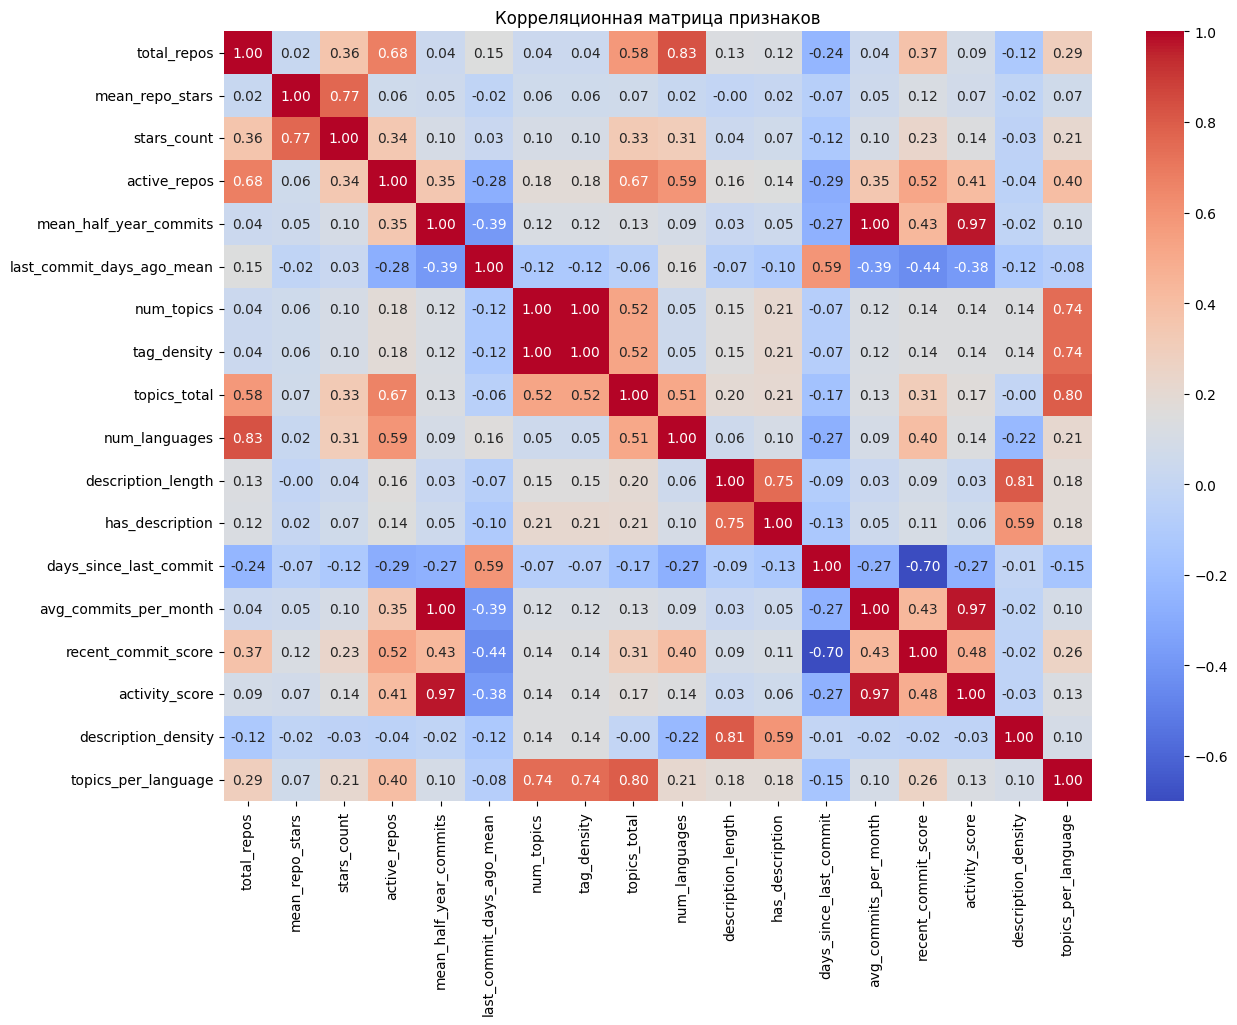

In [4]:
corr = numeric_cols.corr()

plt.figure(figsize=(14, 10))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Корреляционная матрица признаков")
plt.show()

1. Признаки активности (stars, commits, репозитории) формируют взаимосвязанную группу. Часть из них избыточна. (надо объединить)

2. Тематическая насыщенность (topics, tag_density) — один из сильнейших индикаторов популярности.

3. Признаки заброшенности (days_since_last_commit) чётко обратно коррелируют с показателями активности.

4. Описание и языковая разнообразность — независимые, уникальные по смыслу признаки.

5. Для моделей и кластеризации можно убрать дублирующие признаки, оставив наиболее показательные: stars_count, topics_total, activity_score, description_length, recent_commit_score.

## PCA-визуализация (снижение размерности)

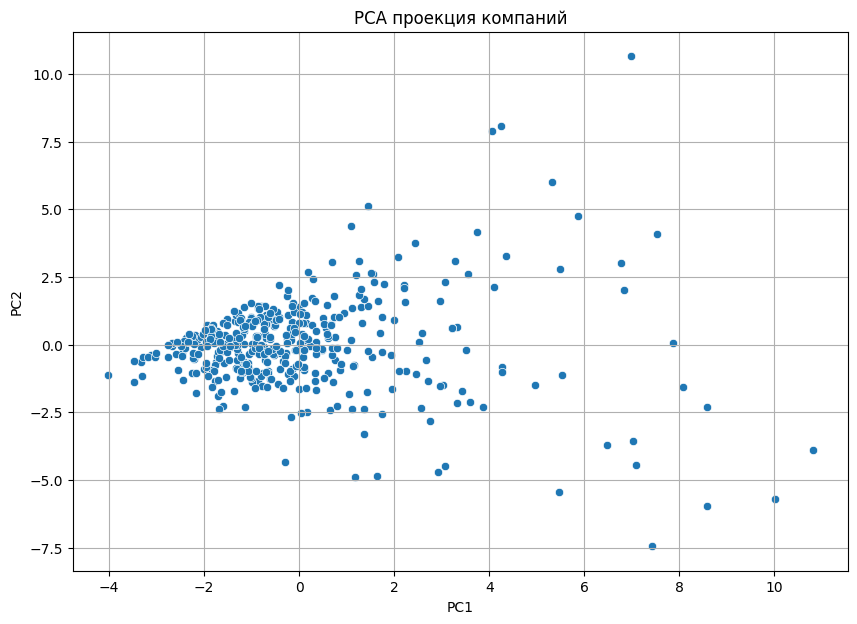

In [5]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X = numeric_cols.fillna(0)
X_scaled = StandardScaler().fit_transform(X)

pca = PCA(n_components=2)
components = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 7))
sns.scatterplot(x=components[:, 0], y=components[:, 1])
plt.title("PCA проекция компаний")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()

1. Данные не полностью линейны — это видно по форме облака. Возможно, стоит попробовать t-SNE или UMAP.

2. Явных кластеров не видно, но выбросы очевидны: отдельные компании сильно выделяются — скорее всего, это крупные и активные компании.

3. PCA-компоненты пригодны для:

    первичного отбора выбросов,
    визуальной оценки «разнообразия» компаний,
    кластеризации и классификации (на основе этих координат или для отбора фичей).


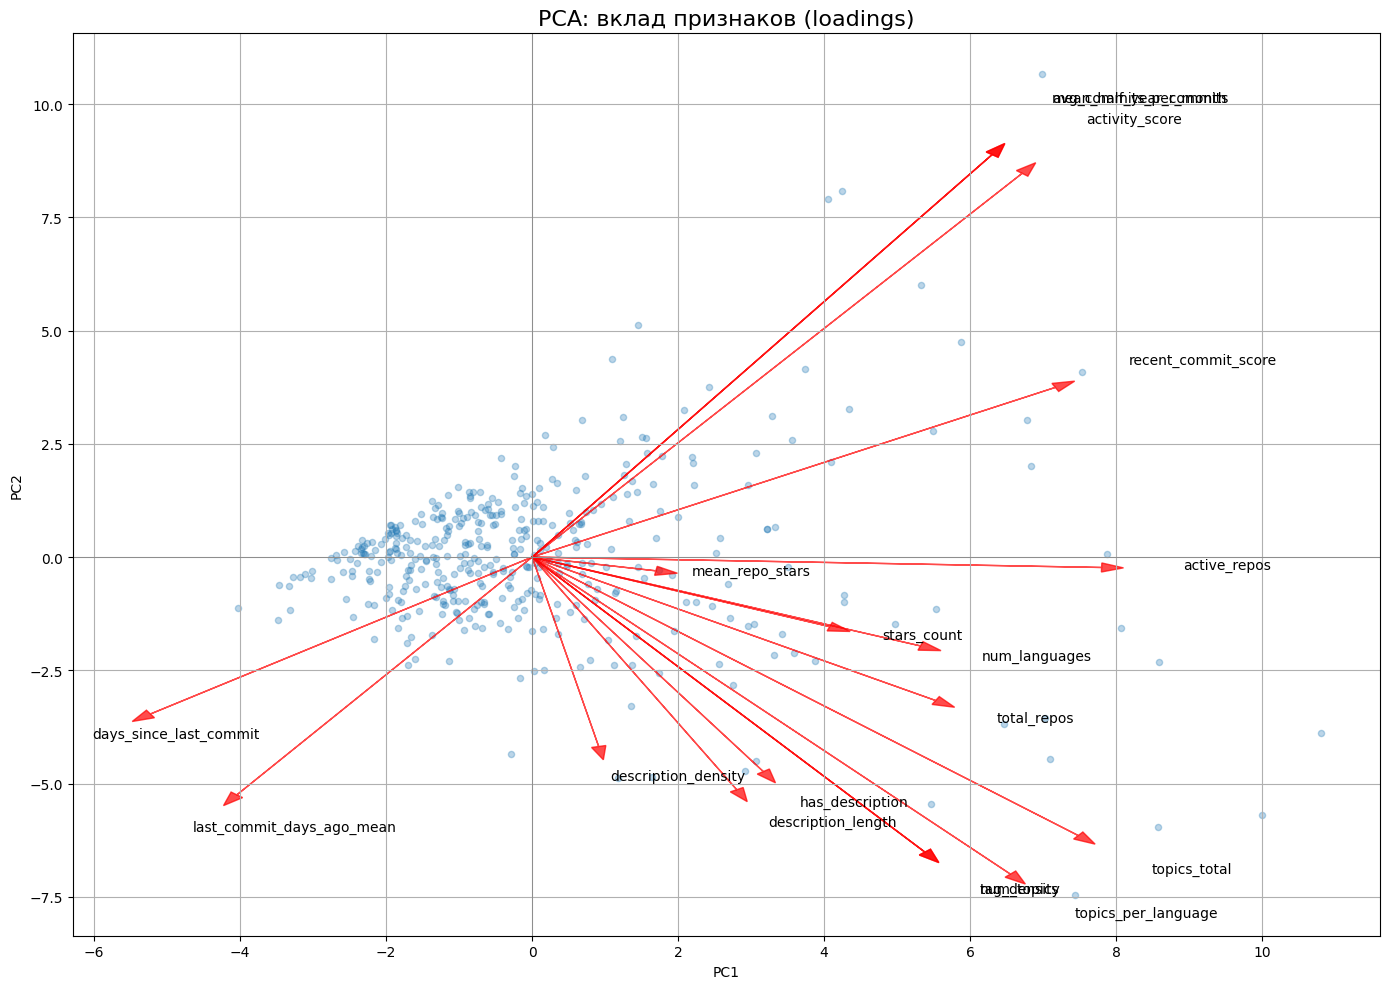

In [6]:
X = features_df.select_dtypes(include='number').fillna(0)
features = X.columns
X_scaled = StandardScaler().fit_transform(X)

# PCA
pca = PCA(n_components=2)
components = pca.fit_transform(X_scaled)
loadings = pca.components_.T

plt.figure(figsize=(14, 10))
plt.scatter(components[:, 0], components[:, 1], alpha=0.3, s=20)

scaling_factor = 24
for i, feature in enumerate(features):
    x, y = loadings[i, 0] * scaling_factor, loadings[i, 1] * scaling_factor
    plt.arrow(0, 0, x, y, color='red', alpha=0.7, head_width=0.2, length_includes_head=True)
    plt.text(x * 1.1, y * 1.1, feature, fontsize=10, color='black')

plt.title("PCA: вклад признаков (loadings)", fontsize=16)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.axhline(0, color='gray', lw=0.5)
plt.axvline(0, color='gray', lw=0.5)
plt.tight_layout()
plt.show()



 ##### 1. Признаки, формирующие PC1 (горизонтальная ось)
Стрелки, направленные вправо (вдоль PC1), обозначают признаки, которые определяют масштаб, активность и зрелость компаний:

    stars_count

    mean_repo_stars
    
    activity_score
    
    mean_half_year_commits
    
    total_repos
    
    active_repos
    
    recent_commit_score

Эти признаки тянут компании вправо — значит, те, кто "высоко" по PC1, вероятно, являются технологически развитыми и активно развивающимися.

 ##### 2. Признаки, формирующие PC2 (вертикальная ось)
Стрелки вверх (PC2) отражают более контекстные и уникальные характеристики:

    description_length, 
    
    description_density
    
    topics_total, 
    
    topics_per_language
    
    tag_density

PC2 помогает отличать компании не по активности, а по структурной насыщенности и качеству их открытых проектов — насколько они полно оформлены, богаты на тематику и разнообразны.

 ##### 3. Признаки, направленные в противоположную сторону
days_since_last_commit, last_commit_days_ago_mean — влево и вниз: они «противоположны» активности и инновационности.

Чем выше значение этих признаков, тем менее активна компания.

has_description, num_languages — слабо выражены, но независимы.

## Анализ выбросов: boxplot для ключевых признаков

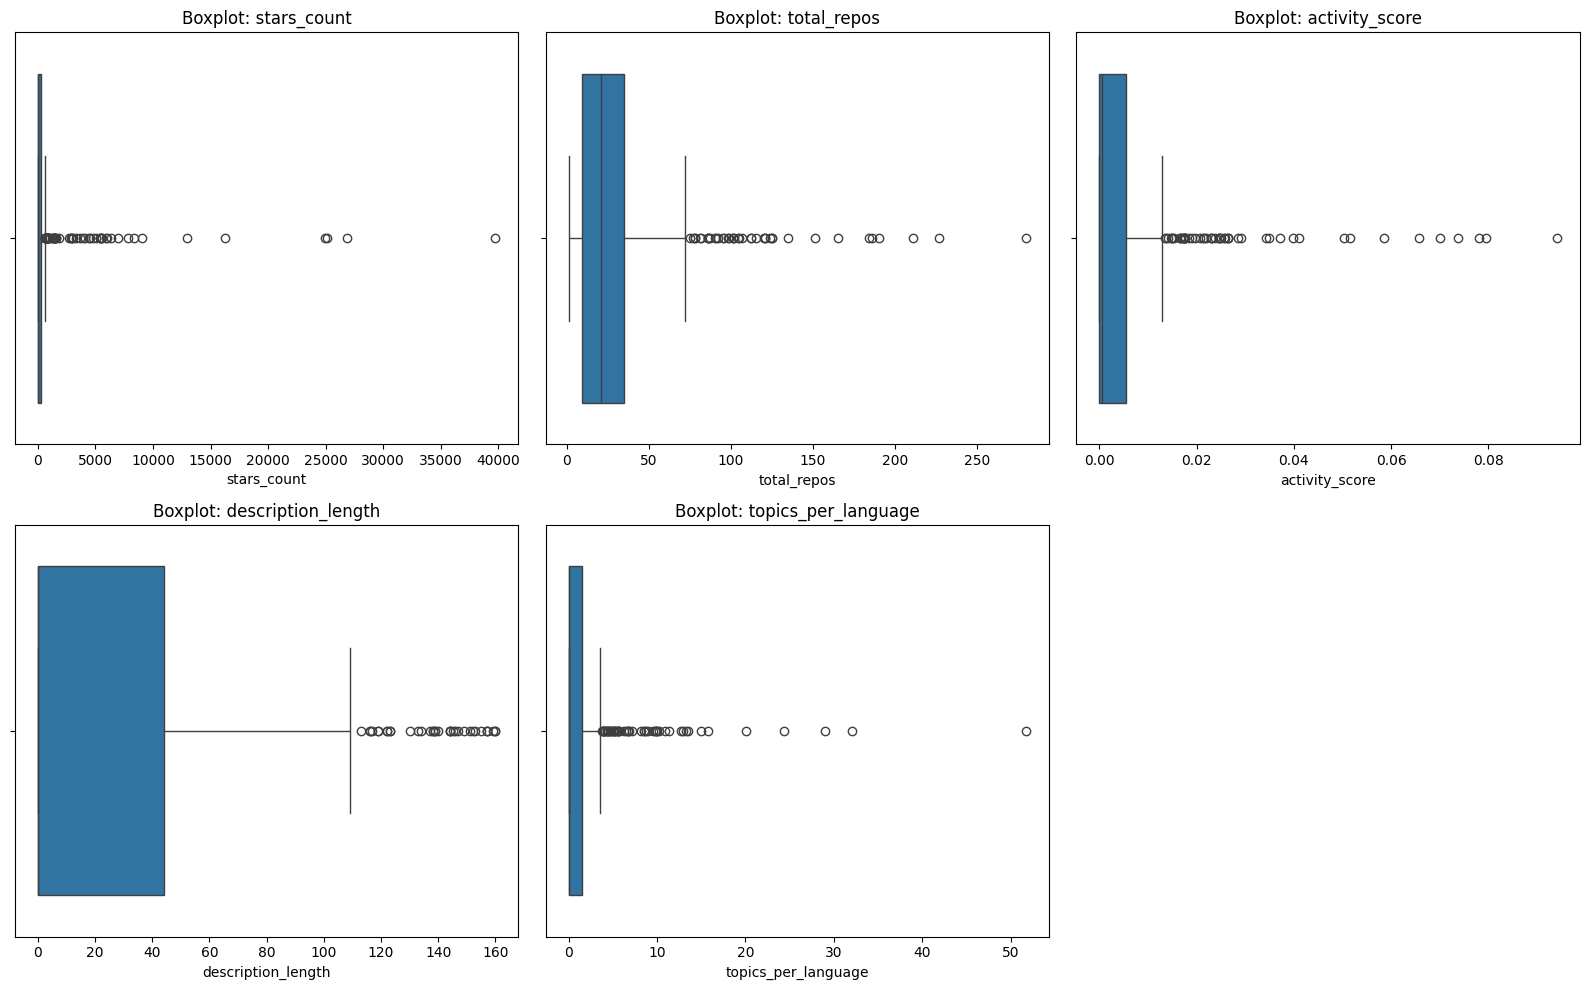

In [7]:
# признаки с частыми выбросами
boxplot_cols = [
    'stars_count', 'total_repos', 'activity_score',
    'description_length', 'topics_per_language'
]

plt.figure(figsize=(16, 10))
for i, col in enumerate(boxplot_cols, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x=features_df[col])
    plt.title(f"Boxplot: {col}")
plt.tight_layout()
plt.show()

Во всех признаках наблюдаются выбросы с крайне высокими значениями, особенно в stars_count и activity_score.

Это соответствует реальности и подтверждает, что в выборке есть как рядовые, так и лидирующие компании.

Такие выбросы не стоит убирать, если цель — отбор перспективных. Но при построении модели — хорошо бы использовать нормализацию.

## Кластеризация: KMeans + визуализация

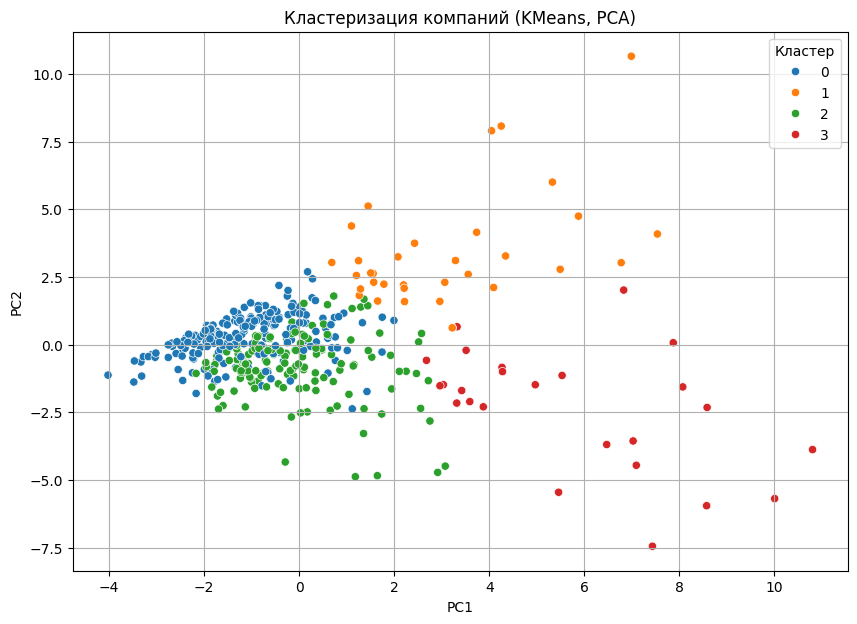

In [8]:
from sklearn.cluster import KMeans

X = features_df.select_dtypes(include='number').fillna(0)
X_scaled = StandardScaler().fit_transform(X)

# Кластеризация
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(X_scaled)
features_df['cluster'] = clusters

# PCA для визуализации
pca = PCA(n_components=2)
components = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 7))
sns.scatterplot(x=components[:, 0], y=components[:, 1], hue=clusters, palette="tab10")
plt.title("Кластеризация компаний (KMeans, PCA)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Кластер")
plt.grid(True)
plt.show()


Компании чётко разделились на 4 кластера, каждый из которых занимает свою зону на карте.
Разделение идёт по основным признаковым осям:
    по оси PC1 — интенсивность разработки и масштаб,
    по оси PC2 — насыщенность, уникальность и оформленность.

##### Кластер 3 (справа внизу, сильно вытянут)
Компании с максимальными значениями активности и популярности (stars_count, activity_score, total_repos).
Здесь сосредоточены самые перспективные или зрелые компании.
Возможно — международные техногиганты, активно продвигающие opensource.

##### Кластер 1 (справа сверху)
Также активные компании, но с меньшим количеством выбросов.
Возможны компании с выраженной тематикой, но не столь высокой "звёздностью".

##### Кластер 2 (центр, рассеян)
Компании с средними значениями признаков.
Вероятно, малые или средние предприятия, активно работающие, но без массовой популярности.

##### Кластер 0 (слева)
Большая масса — малоактивные или начинающие.
Возможно, временно неактивные или нишевые компании с минимальной открытой разработкой.

### Cредние значения признаков по кластерам

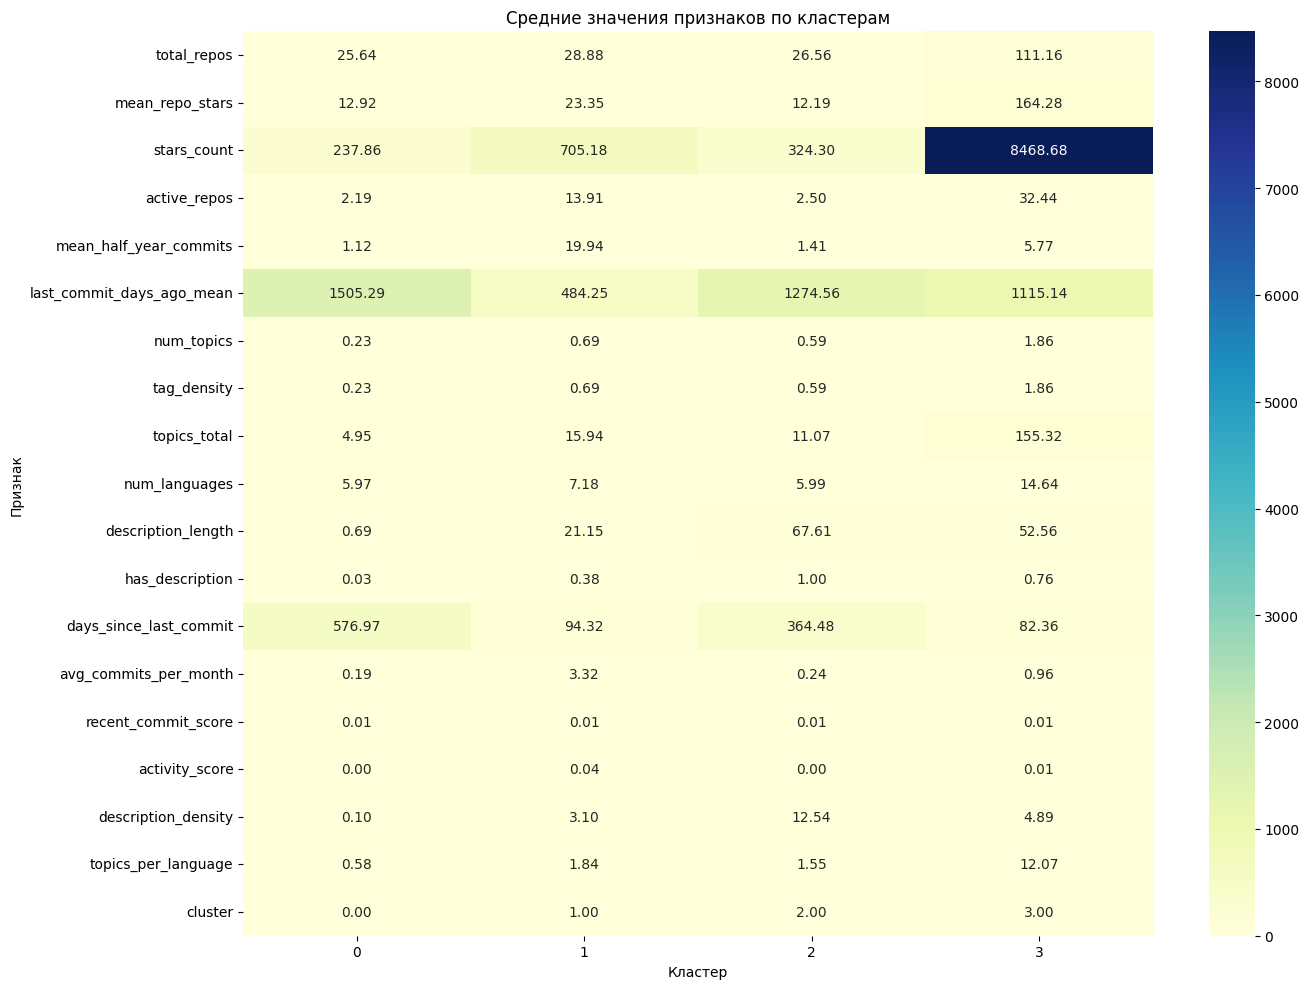

In [9]:
numeric_cols = features_df.select_dtypes(include='number')
clustered_means = numeric_cols.groupby(features_df['cluster']).mean().T
clustered_means_rounded = clustered_means.round(2)

plt.figure(figsize=(14, 10))
sns.heatmap(clustered_means_rounded, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("Средние значения признаков по кластерам")
plt.xlabel("Кластер")
plt.ylabel("Признак")
plt.tight_layout()
plt.show()


## Feature importance через surrogate target

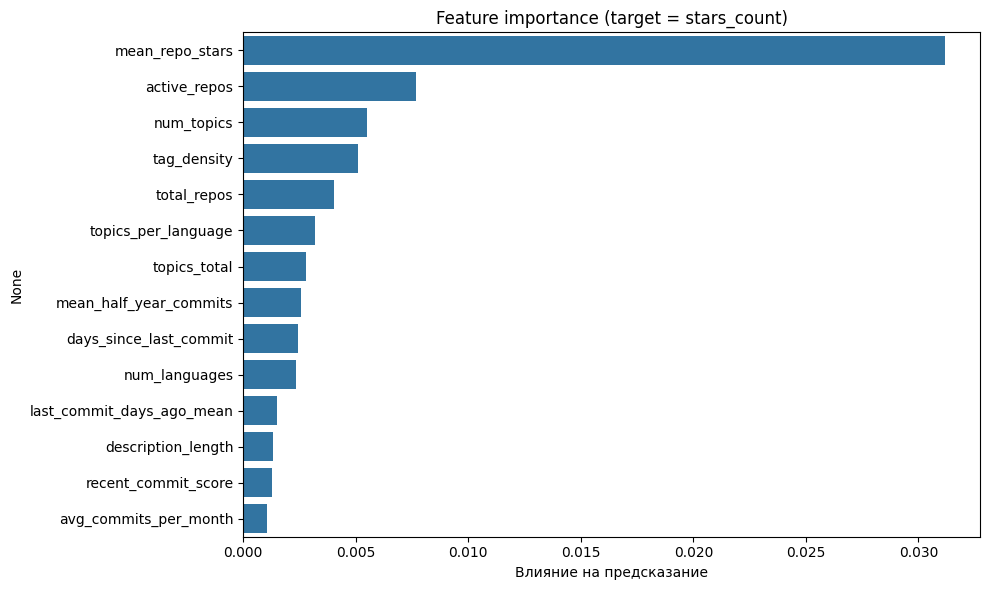

In [10]:
from sklearn.ensemble import RandomForestRegressor

target = features_df['stars_count']
model = RandomForestRegressor(random_state=42)
model.fit(X_scaled, target)

importances = model.feature_importances_
feature_names = X.columns

# Топ 15 признаков
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)[:15]

plt.figure(figsize=(10, 6))
sns.barplot(x=feat_imp[1:].values, y=feat_imp[1:].index)
plt.title("Feature importance (target = stars_count)")
plt.xlabel("Влияние на предсказание")
plt.tight_layout()
plt.show()


##### Топ признаков:
mean_repo_stars — самый значимый показатель. Логично, ведь он напрямую связан с целевым значением.

active_repos — отражает уровень разработки, часто коррелирует с популярностью.

num_topics, tag_density — тематическая насыщенность, влияет на восприятие и «обнаруживаемость» репозитория.

total_repos, topics_per_language, topics_total — размер и структурное богатство проекта.

description_length, recent_commit_score, days_since_last_commit — вторичные, но важные признаки зрелости и прозрачности.

Главные признаки соотносятся с популярностью и открытостью: не просто активность, а продуманное оформление, структура и тематическая целенаправленность.
Это подтверждает, что наиболее «звёздные» компании — это не только активные, но и те, кто умеет делать свою разработку понятной и насыщенной.

## TF-IDF анализ name_parts и repo_topics

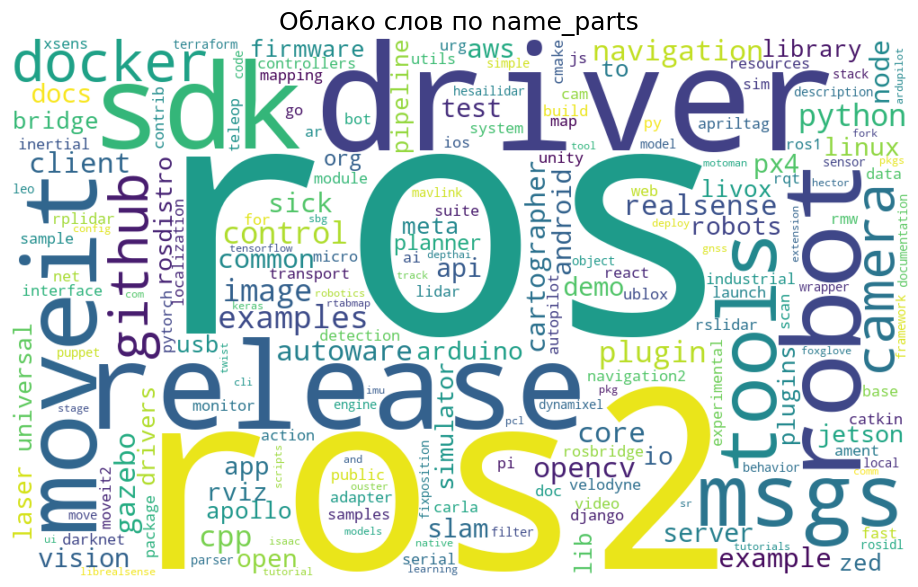

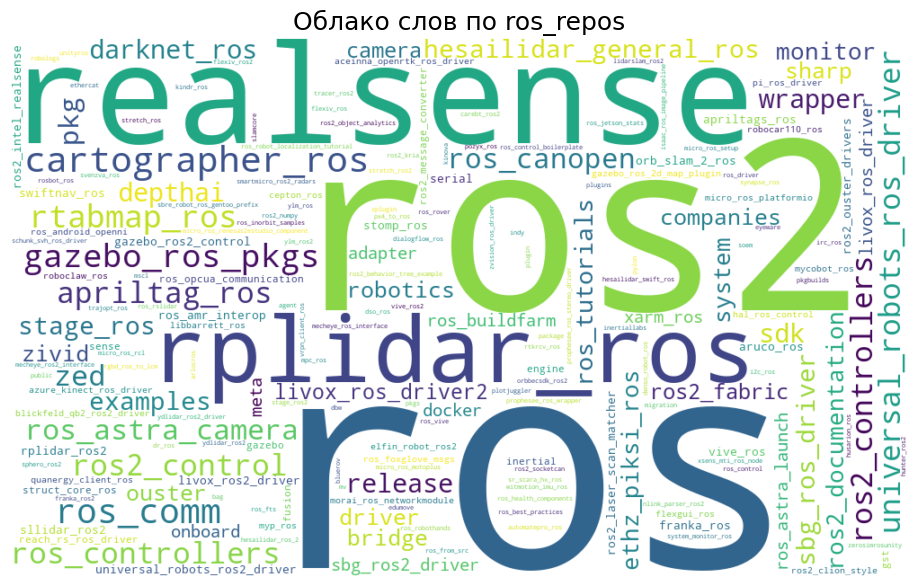

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt

name_corpus = features_df['name_parts'].fillna('').apply(lambda x: ' '.join(eval(x)) if x != '[]' else '')
topic_corpus = features_df['ros_repos'].fillna('').apply(lambda x: ' '.join(eval(x)) if x != '[]' else '')

vectorizer_name = TfidfVectorizer()
name_tfidf = vectorizer_name.fit_transform(name_corpus)

vectorizer_topic = TfidfVectorizer()
topic_tfidf = vectorizer_topic.fit_transform(topic_corpus)

# облака слов по tf-idf
def plot_wordcloud(tfidf_matrix, vectorizer, title):
    scores = tfidf_matrix.sum(axis=0).A1
    words = vectorizer.get_feature_names_out()
    word_scores = dict(zip(words, scores))

    wordcloud = WordCloud(width=1000, height=600, background_color='white').generate_from_frequencies(word_scores)

    plt.figure(figsize=(12, 7))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=18)
    plt.show()

plot_wordcloud(name_tfidf, vectorizer_name, "Облако слов по name_parts")
plot_wordcloud(topic_tfidf, vectorizer_topic, "Облако слов по ros_repos")



## Разметка

In [12]:
def interpret_cluster(c):
    if c == 3:
        return "high_potential"
    elif c == 1:
        return "stable_growth"
    elif c == 2:
        return "niche_tech"
    elif c == 0:
        return "archived"

features_df['company_type'] = features_df['cluster'].apply(interpret_cluster)
features_df.head(4)

,organization,top 3 repo,languages,ros_repos,name_parts,total_repos,mean_repo_stars,stars_count,active_repos,mean_half_year_commits,...,description_length,has_description,days_since_last_commit,avg_commits_per_month,recent_commit_score,activity_score,description_density,topics_per_language,cluster,company_type
0,ros-acceleration,"['robotic_processing_unit', 'community', 'acce...","['Cuda', 'Python', 'C++', 'Tcl', 'C', 'CMake']","['ros2_kria', 'isaac_ros_image_pipeline']","['community', 'ament', 'vitis', 'acceleration'...",20.0,15.650000,313.0,1.0,0.100000,...,86,1,150.0,0.016667,0.006623,0.000110,14.333333,15.00000,2,niche_tech
1,Aceinna,"['gnss-ins-sim', 'python-openimu', 'platform-a...","['JavaScript', 'Shell', 'MATLAB', 'M', 'Python...",['aceinna_openrtk_ros_driver'],"['platform', 'aceinna_imu', 'python', 'imu380'...",33.0,45.272727,1494.0,2.0,0.121212,...,106,1,166.0,0.020202,0.005988,0.000121,15.142857,1.00000,2,niche_tech
2,Accenture,"['adop-docker-compose', 'Ocaramba', 'adop-jenk...","['PowerShell', 'JavaScript', 'Thrift', 'R', 'C...",[],"['mahout', 'timeseriesr', 'environment', 'dash...",211.0,42.890995,9050.0,32.0,3.530806,...,21,1,81.0,0.588468,0.012195,0.007176,0.656250,8.53125,3,high_potential
3,accerion,"['gazebo_ros_2d_map_plugin', 'librover', 'pepp...","['Shell', 'Julia', 'Python', 'C++', 'CMake', '...",['gazebo_ros_2d_map_plugin'],"['gazebo', 'ros', '2d', 'map', 'plugin', 'libr...",5.0,0.000000,0.0,1.0,0.400000,...,0,0,151.0,0.066667,0.006579,0.000439,0.000000,0.00000,0,archived


In [13]:
features_df.to_csv("features_with_labels.csv", index=False)

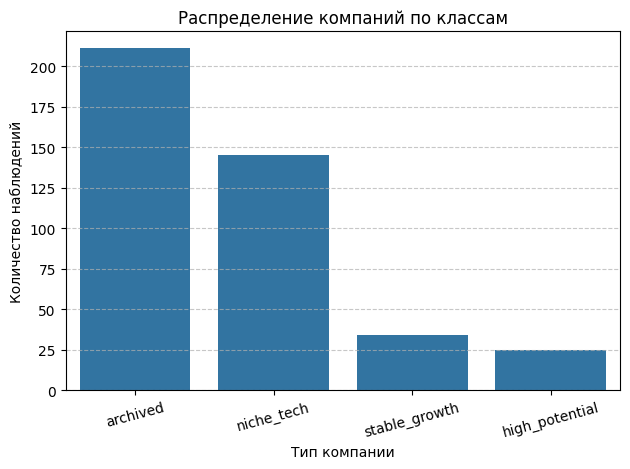

In [15]:
sns.countplot(data=features_df, x="company_type", order=features_df["company_type"].value_counts().index)
plt.title("Распределение компаний по классам")
plt.xlabel("Тип компании")
plt.ylabel("Количество наблюдений")
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
